# Case 5: A Study on Imputation
*Dustin Bracy, Paul Huggins, Grace Lang & Branum Stephans*

## Business Background: 
This analysis will utilize the California Housing dataset and build models to test the validity and performance impact of different imputation methods on model predictions. The results can serve to help a data analyst with weighing the pros and cons of imputation and when certain methods are preferred over others.

In [1]:
# Import package dependencies
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn import datasets

from plydata import *
from plotnine import *

### California Housing data description:

This block loads the dataset, checks the shape of the data and examines the contents of the California Housing data object.  

In [2]:
california = datasets.fetch_california_housing()
print('data shape:', california.data.shape)
print(california.keys())

print(california.DESCR)

data shape: (20640, 8)
dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one r

In [3]:
# Convert the matrix to pandas
cal = pd.DataFrame(california.data)
cal.columns = california.feature_names
cal['MedHouseVal'] = california.target
cal.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
cal.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


# Baseline Model Development

## Fitting a Linear Regression model with full dataset

*Create a training and testing split (ex., 70/30-split)*

In [5]:
# Create training and testing sets (cross-validation not needed)
train_set = cal.sample(frac=0.7, random_state=100)
test_set = cal[~cal.isin(train_set)].dropna()
print(train_set.shape[0])
print(test_set.shape[0])

14448
6192


In [6]:
# Get the training and testing row indices for later use
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)

# Converting the training and testing datasets back to matrix-formats
X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target-only
X_test = test_set.iloc[:, 0:8].values # ""
Y_test = test_set.iloc[:, -1].values # ""

# Fit a linear regression to the training data
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)
print(reg.intercept_)
print(reg.get_params())

0.6160214522398206
[ 4.59063361e-01  9.72601795e-03 -1.37408894e-01  8.20058010e-01
 -5.20832695e-06 -3.38987100e-03 -4.12859546e-01 -4.28244613e-01]
-36.61483864947019
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True, 'positive': False}


In [7]:
# Find the variable with the largest "normalized" coefficient value
print('The positive(max) coef-value is {}'.format(max(reg.coef_))) # Positive Max
#print('The abs(max) coef-value is {}'.format(max(reg.coef_, key=abs))) # ABS Max
max_var = max(reg.coef_) # Positive Max
#max_var = max(reg.coef_, key=abs) # ABS Max
var_index = reg.coef_.tolist().index(max_var)
print('The variable associated with this coef-value is {}'.format(california.feature_names[var_index]))

The positive(max) coef-value is 0.8200580100743733
The variable associated with this coef-value is AveBedrms


In [8]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = mean_squared_error(Y_test,Y_pred, squared=False)
orig_r2 = r2_score(Y_test,Y_pred)

print("MAE: %.3f"%orig_mae)
print("MSE:  %.3f"%orig_mse)
print("RMSE:  %.3f"%orig_rmse_val)
print("R2:  %.3f"%orig_r2)

MAE: 0.537
MSE:  0.556
RMSE:  0.746
R2:  0.580


In [9]:
res_frame = pd.DataFrame({'data':'Baseline',
                   'imputation':'None',
                   'Nulls Replaced':'None',
                   'mae': orig_mae, 
                   'mse': orig_mse, 
                   'rmse':orig_rmse_val, 
                   'R2':orig_r2,
                   'mae_diff':np.nan,
                   'mse_diff':np.nan,
                   'rmse_diff':np.nan,
                   'R2_diff':np.nan}, index=[0])

res_frame

,data,imputation,Nulls Replaced,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,Baseline,None,None,0.53676,0.556336,0.74588,0.58016,NaN,NaN,NaN,NaN


In [10]:
# What columns should we look into replacing?
cal.isna().any().any()
cal.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Feature Importance
Below are normalized and ranked Gini scores for each feature returned from a random forest regressor executed on the training dataset.  Gini scores are a meaure of impurity for each feature, and are used by the regression trees to determine where to split, or separate classes of a node.  This impurity score can be described as a calculation of probability that a feature will be classified incorrectly when randomly selected.

[https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8]

In [11]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train, Y_train)

# Get Random Forest Gini Importance
coefs = clf.feature_importances_
labels = cal.columns
RF_coefs = pd.DataFrame(
    zip(labels,coefs), 
    columns=['Feature','Feature_Importance']).sort_values(
    by='Feature_Importance', ascending=False)

RF_coefs

,Feature,Feature_Importance
0,MedInc,0.524523
5,AveOccup,0.140073
6,Latitude,0.088558
7,Longitude,0.088284
1,HouseAge,0.053701
2,AveRooms,0.045311
3,AveBedrms,0.030916
4,Population,0.028634


# Missing Completely at Random

"Select 1%, 5% 10%, 20%, 33%, and 50% of your data in a single column **hold that column selection constant throughout all iterations** (Completely at random), replace the original value with a NaN (i.e., “not a number” – ex., np.nan) and then perform an imputation for the missing values.

In each case **1%, 5%, 10%, 20%, 33%, 50%** perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.  
**Note: you should have (6) models to compare against your baseline at this point.**"


In [12]:
def run_MAR_loop(NA_percent:int, res_frame):
    # Randomly sample full dataset and replace 1 column
    in_sample = cal.sample(frac=NA_percent/100, random_state=99)

    out_sample = cal[~cal.isin(in_sample)].dropna()
    in_sample['MedInc'] = np.nan
    count_null = in_sample['MedInc'].isnull().sum()

    # Replace using average
    in_sample['MedInc'] = in_sample['MedInc'].fillna(out_sample['MedInc'].mean())

    # Combine the 2 datasets
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()

    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]

    # Converting the training and testing datasets back to matrix-formats
    X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
    Y_train = train_set.iloc[:, -1].values # returns the target-only
    X_test = test_set.iloc[:, 0:8].values # ""
    Y_test = test_set.iloc[:, -1].values # ""

    reg2 = LinearRegression().fit(X_train, Y_train)
    # print(reg2.score(X_train, Y_train))
    # print(reg2.coef_)
    # print(reg2.intercept_)
    # print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = mean_squared_error(Y_test,Y_pred, squared=False)
    r2 = r2_score(Y_test,Y_pred)

    temp_frame = pd.DataFrame({'data':'{}% imputed'.format(NA_percent),
                    'imputation':'Mean MedInc',
                    'Nulls Replaced':count_null,
                    'mae': mae, 
                    'mse': mse, 
                    'rmse':rmse_val,
                    'R2':r2,
                    'mae_diff':mae-orig_mae,
                    'mse_diff':mse-orig_mse,
                    'rmse_diff':rmse_val-orig_rmse_val,
                    'R2_diff':r2-orig_r2
                    }, index=[0])
    return pd.concat([res_frame, temp_frame])

In [13]:
MAR_loops = [1, 5, 10, 20, 33, 50]

for NA_val in MAR_loops:
    res_frame = run_MAR_loop(NA_val, res_frame)

res_frame

,data,imputation,Nulls Replaced,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,Baseline,None,None,0.536760,0.556336,0.745880,0.580160,NaN,NaN,NaN,NaN
0,1% imputed,Mean MedInc,206,0.539811,0.560472,0.748647,0.577039,0.003051,0.004136,0.002767,-0.003121
0,5% imputed,Mean MedInc,1032,0.553542,0.581813,0.762767,0.560934,0.016782,0.025477,0.016887,-0.019226
0,10% imputed,Mean MedInc,2064,0.568179,0.606796,0.778971,0.542081,0.031419,0.050460,0.033092,-0.038079
0,20% imputed,Mean MedInc,4128,0.590720,0.640540,0.800338,0.516615,0.053960,0.084204,0.054458,-0.063545
0,33% imputed,Mean MedInc,6811,0.619237,0.689969,0.830644,0.479314,0.082477,0.133633,0.084764,-0.100846
0,50% imputed,Mean MedInc,10320,0.643806,0.737968,0.859050,0.443092,0.107045,0.181631,0.113171,-0.137068


### As expected, when removing information from the data, RMSE increases and Pearson's R${^2}$ decreases.  This is a good indication of declining performance as we impute a higher percentage of data. The R${^2}$ drops nearly 14% when half of the data is missing, meaning roughly 14% of the variance in median income on block value can no longer be explained by the data.

# Missing at Random (30pt)

"Take one column and create data “Missing at Random” when controlled for a second variable (i.e., if Variable Z is > 30, then Variables X is randomly missing).  Use your preferred imputation method to fill in 10%, 20% and 30% of your missing data.

In each case [10%, 20%, 30%] perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.  [Note: you should have (9) new models to 

In [14]:
deep_copy = cal.copy()
filter_threshold = deep_copy['HouseAge'] > 37
sample_percentage = 0.5

samples = list(deep_copy[filter_threshold].sample(frac=sample_percentage).index)
deep_copy.loc[deep_copy.index.isin(samples), 'MedInc'] = None


In [15]:
def run_MAR_2_loop(NA_percent:int, res_frame):
    # Randomly sample full dataset and replace 1 column
    
    # generate copy of cal set for safe updates
    deep_copy = cal.copy()
    
    # create a filter criteria for specified case 
    filter_threshold = deep_copy['HouseAge'] > 37
    
    # create a random index of values over specified threshold
    samples = list(deep_copy[filter_threshold].sample(frac=NA_percent/100).index)
    
    
    # generate in and out sample for comparison
    in_sample = deep_copy.sample(frac=NA_percent/100, random_state=99)
    out_sample = cal[~cal.isin(in_sample)].dropna()


    # set nulls randomly to None based on the criteria
    in_sample.loc[in_sample.index.isin(samples), 'MedInc'] = None
    
    # get null counts for metrics purposes
    count_null = in_sample['MedInc'].isnull().sum()
    
    
    # Replace using average
    in_sample['MedInc'] = in_sample['MedInc'].fillna(out_sample['MedInc'].mean())

    # Combine the 2 datasets
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()
    
    # create test train splits based on previous samples
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]

    # Converting the training and testing datasets back to matrix-formats
    X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
    Y_train = train_set.iloc[:, -1].values # returns the target-only
    X_test = test_set.iloc[:, 0:8].values # ""
    Y_test = test_set.iloc[:, -1].values # ""

    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = mean_squared_error(Y_test,Y_pred, squared=False)
    r2 = r2_score(Y_test,Y_pred)
    
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)

    temp_frame = pd.DataFrame({'data':'{}% imputed'.format(NA_percent),
                    'imputation':'Mean MedInc if HouseAge >= 37',
                    'Nulls Replaced':count_null,
                    'mae': mae, 
                    'mse': mse, 
                    'rmse':rmse_val,
                    'R2':r2,
                    'mae_diff':mae-orig_mae,
                    'mse_diff':mse-orig_mse,
                    'rmse_diff':rmse_val-orig_rmse_val,
                    'R2_diff':r2-orig_r2
                    }, index=[0])
    return pd.concat([res_frame, temp_frame])

In [16]:
MAR_2_loops = [10, 20, 30]

for NA_val in MAR_2_loops:
    res_frame = run_MAR_2_loop(NA_val, res_frame)

0.6140010655412571
[ 4.56549295e-01  9.69461324e-03 -1.33657181e-01  8.03376138e-01
 -5.27971205e-06 -3.37924313e-03 -4.15150582e-01 -4.30383198e-01]
-36.78041588390427
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
MAE: 0.538
MSE:  0.559
RMSE:  0.748
R2:  0.578
0.6079551984769278
[ 4.49868135e-01  9.47103054e-03 -1.21962627e-01  7.52945571e-01
 -6.04857548e-06 -3.34038574e-03 -4.22277293e-01 -4.36594917e-01]
-37.24609755172564
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
MAE: 0.540
MSE:  0.562
RMSE:  0.750
R2:  0.576
0.603551065437216
[ 4.44757292e-01  9.20126976e-03 -1.13755598e-01  7.17447149e-01
 -5.85489722e-06 -3.31145708e-03 -4.26795683e-01 -4.40177166e-01]
-37.4945805973362
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
MAE: 0.545
MSE:  0.570
RMSE:  0.755
R2:  0.570


In [17]:
res_frame.tail()

,data,imputation,Nulls Replaced,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,33% imputed,Mean MedInc,6811,0.619237,0.689969,0.830644,0.479314,0.082477,0.133633,0.084764,-0.100846
0,50% imputed,Mean MedInc,10320,0.643806,0.737968,0.859050,0.443092,0.107045,0.181631,0.113171,-0.137068
0,10% imputed,Mean MedInc if HouseAge >= 37,51,0.537944,0.558842,0.747557,0.578269,0.001184,0.002506,0.001678,-0.001891
0,20% imputed,Mean MedInc if HouseAge >= 37,196,0.539851,0.561969,0.749646,0.575909,0.003090,0.005633,0.003766,-0.004251
0,30% imputed,Mean MedInc if HouseAge >= 37,455,0.545236,0.569787,0.754842,0.570009,0.008475,0.013451,0.008963,-0.010151


# Missing "Not at" Random (20pt)

"Create a “Missing Not at Random” pattern in which 25% of the data is missing for a single column.  Use your preferred imputation method to fill in the missing values.

Perform a fit with the imputed data [25%] and compare the loss and goodness of fit to your baseline.  [Note: you should have (10) models to compare against your baseline at this point.]"

In [18]:
def run_MAR_3_loop(NA_percent:int, res_frame):
    # Randomly sample full dataset and replace 1 column
    in_sample = cal.sample(frac=NA_percent/100, random_state=99)

    out_sample = cal[~cal.isin(in_sample)].dropna()
    
    
    sample_indices = in_sample['MedInc'].sample(frac=0.25).index.values
    in_sample.loc[in_sample.index.isin(sample_indices), "MedInc"] = None
    count_null = in_sample['MedInc'].isnull().sum()
    
    in_sample['MedInc'] = in_sample['MedInc'].fillna(out_sample['MedInc'].mean())
    
    # Combine the 2 datasets
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()

    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]

    # Converting the training and testing datasets back to matrix-formats
    X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
    Y_train = train_set.iloc[:, -1].values # returns the target-only
    X_test = test_set.iloc[:, 0:8].values # ""
    Y_test = test_set.iloc[:, -1].values # ""

    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)
    
    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = mean_squared_error(Y_test,Y_pred, squared=False)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    
    temp_frame = pd.DataFrame({'data':'{}% imputed'.format(NA_percent),
                    'imputation':'Mean MedInc on 25% of data',
                    'Nulls Replaced':count_null,
                    'mae': mae, 
                    'mse': mse, 
                    'rmse':rmse_val,
                    'R2':r2,
                    'mae_diff':mae-orig_mae,
                    'mse_diff':mse-orig_mse,
                    'rmse_diff':rmse_val-orig_rmse_val,
                    'R2_diff':r2-orig_r2
                    }, index=[0])
    return pd.concat([res_frame, temp_frame])
    
        
MAR_3_loops = [25]

for NA_val in MAR_3_loops:
    res_frame = run_MAR_3_loop(NA_val, res_frame)

0.5856083979594284
[ 4.19119918e-01  9.25486337e-03 -6.83854278e-02  5.18796814e-01
 -6.85859702e-06 -3.15507925e-03 -4.57606431e-01 -4.69713000e-01]
-39.85501314738252
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
MAE: 0.557
MSE:  0.591
RMSE:  0.769
R2:  0.554


In [19]:
res_frame['variant'] = res_frame.apply(lambda x: x['data'] + " " + x['imputation'], axis=1)

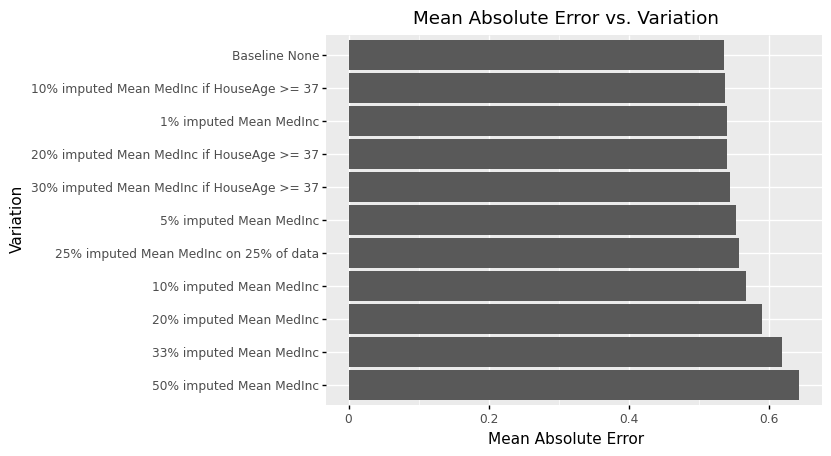

<ggplot: (150624343703)>

In [20]:
res_frame >> ggplot(aes(x='reorder(variant, -mae)', y='mae'))\
+ geom_bar(stat='identity') + coord_flip() + ggtitle("Mean Absolute Error vs. Variation")\
+ ylab("Mean Absolute Error") + xlab("Variation")

# Conclusion (10pt)

Describe your imputation approach and summarize your findings.  What impact did the missing data have on your baseline model’s performance?  Did anything surprise you?

In [21]:
res_frame

,data,imputation,Nulls Replaced,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff,variant
0,Baseline,None,None,0.536760,0.556336,0.745880,0.580160,NaN,NaN,NaN,NaN,Baseline None
0,1% imputed,Mean MedInc,206,0.539811,0.560472,0.748647,0.577039,0.003051,0.004136,0.002767,-0.003121,1% imputed Mean MedInc
0,5% imputed,Mean MedInc,1032,0.553542,0.581813,0.762767,0.560934,0.016782,0.025477,0.016887,-0.019226,5% imputed Mean MedInc
0,10% imputed,Mean MedInc,2064,0.568179,0.606796,0.778971,0.542081,0.031419,0.050460,0.033092,-0.038079,10% imputed Mean MedInc
0,20% imputed,Mean MedInc,4128,0.590720,0.640540,0.800338,0.516615,0.053960,0.084204,0.054458,-0.063545,20% imputed Mean MedInc
0,33% imputed,Mean MedInc,6811,0.619237,0.689969,0.830644,0.479314,0.082477,0.133633,0.084764,-0.100846,33% imputed Mean MedInc
0,50% imputed,Mean MedInc,10320,0.643806,0.737968,0.859050,0.443092,0.107045,0.181631,0.113171,-0.137068,50% imputed Mean MedInc
0,10% imputed,Mean MedInc if HouseAge >= 37,51,0.537944,0.558842,0.747557,0.578269,0.001184,0.002506,0.001678,-0.001891,10% imputed Mean MedInc if HouseAge >= 37
0,20% imputed,Mean MedInc if HouseAge >= 37,196,0.539851,0.561969,0.749646,0.575909,0.003090,0.005633,0.003766,-0.004251,20% imputed Mean MedInc if HouseAge >= 37
0,30% imputed,Mean MedInc if HouseAge >= 37,455,0.545236,0.569787,0.754842,0.570009,0.008475,0.013451,0.008963,-0.010151,30% imputed Mean MedInc if HouseAge >= 37


Of course, with the full amount of data the baseline linear regression model had the lowest RMSE. All of the other imputation models had a less accurate linear regression. One thing that was observed was if we have the ability to impute data based on some kind of business background then we can reduce the error in the model. For example, when 30% of data will be imputed when the age of the house is above 37 years it has a similar RMSE to 10% of overall imputed data for median income in the block. 

An interesting observation shows that Pearson's R${^2}$ only decreased by approximately 14% when half of the most significant was imputed using the mean. Pearson's R${^2}$ essentially measures the percent of variation in the response captured by the target feature, and so it is somewhat intuitive that the score decreases as we replace more and more data with the mean value of the feature.  However, a 50% reduction in data only results in a 14% decrease in R${^2}$, and ultimately only resulted in an 11% increase in RMSE when 50% of the data was missing.

Looking at the 1st round of imputation - The RMSE decreased roughly 2% as the % imputed increased.  
Looking at the 2nd round of imputation - The RMSE decreased roughly 1% as the % imputed increased.  

Missing Completely At Random data appears to have the largest negative effect on model performance, while data missing at random has the least negative effect.  Imputating a column based on another column appears to have yielded slightly better results than purely using the mean as the imputation method.  

In conclusion, the research on this data suggests that thoughtful imputation strategies can be an effective solution to missing data without terribly skewing model performance results, especially when the total percentage of imputed data makes up 10% or less than the overall dataset.